# Federated Learning for Intrusion Detection 101

<a href="https://colab.research.google.com/github/phdcybersec/teaching/blob/main/tutorials/fl_for_ids_101_cyberschool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to this introduction to using federated learning (FL) for intrusion detection!

In this notebook, we'll learn how to build a collaborative intrusion detection system (IDS), using [Tensorflow](https://www.tensorflow.org) and the [Flower](https://flower.dev) framework. In part I., we train a ML model to classify intrusion in network flows. In part II., we try to train the same model on locally collected data. Finally, in part III., we use FL to collaboratively train the model, benefiting from the experience of the others.

> Hey, I'm Leo 👋
> 
> I’m a doctoral researcher at [IMT Atlantique](https://imt-atlantique.fr) and founded by the chair [Cyber CNI](https://cybercni.fr). My research focuses on collaboration in security systems, and how to share data without compromising on security. I study tools like FL for such purposes. 
>
> You can find the sources of this notebook on [Github](https://github.com/phdcybersec/teaching), and more on me on [my website](https://leolavaur.re).

Let's get stated!

## Use case and context

You're in charge experimenting on novel intrusion detection techniques at your organization. Thanks to the effort of your security operation center (SOC), you have access to labelled network flow, with different attack classes. However, as labelling is extremely resource-consuming, you are limited in data quantity.

We will use NSL-KDD, a well known dataset for intrusion detection <a name="ref1"></a>[\[1\]](#note1), to represent the labeled data. However, only a tenth of it is produced by your organization. The other 90% come from other similar institutions working on the same task: you do not have access to their data.

Commercial agreements are of no help here. Your hierarchy refuses to share any form of collected data, as it might expose sensitive information. Furthermore, as labeled data has value, the other companies won't share it either. Your goal is to build as collaborative system that you can use with your peers from other organizations to benefit from the experience and training of each other.

## Prerequisites

Before we begin with any actual code, let's make sure that we have everything we need:
- some python packages for ML and data processing;
- the NSL-KDD dataset.

In [ ]:
# check if we are running on Google Colab
if "google.colab" in str(get_ipython()):
    # Since the release of Pydantic 2.0, Ray clients die silently during fit, due to API changes
    # in this update. Ray 2.6 or Flower 1.6 will fix the issue.
    # see:
    #  - https://github.com/ray-project/ray/pull/37000
    #  - https://github.com/adap/flower/pull/2002
    !pip install -q flwr[simulation] tensorflow "pydantic<2" matplotlib pandas numpy sklearn
else:
    # if not, we assume we are running on a local machine were dependencies are already
    # installed; cd to a temporary directory to avoid cluttering the current directory
    
    import os
    try:
        os.mkdir("/tmp/nslkdd")
    except FileExistsError:
        pass
    os.chdir("/tmp/nslkdd")
!curl -Lo nslkdd.zip http://205.174.165.80/CICDataset/NSL-KDD/Dataset/NSL-KDD.zip
!unzip -o -d nslkdd nslkdd.zip && rm nslkdd.zip
    


Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [ ]:
import os
from collections import OrderedDict
from typing import List, Tuple

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from flwr.common import Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from numpy.typing import ArrayLike, NDArray

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

# Make keras available in this namespace (for IntelliSense)
keras = tf.keras

To run this notebook more confortably, consider using a machine with a GPU. On Google Colab, go to `Runtime > Change runtime type > Hardware acclerator: GPU > Save`.

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Finally, we will set the seed for our PRNGs (pseudo-random number generators), thus making sure that our experiments will always produce the same results. Keras provides a nice API that does exactly this. We also enable Tensorflow's "determinism", which avoids concurrent calls to return theiur values in a different order. Without it, ML computations will vary between runs, even with the seed <a name="ref3"></a>[\[3\]](#note3).

In [ ]:
SEED = 1138

tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

## Part I. Reviewing the baseline

In this section, we build a deep learning (DL) model on NSL-KDD, due to their performance.

We start with a *perfect* scenario where we have access to the entire dataset at once. It would mean that, either your organization did a massive effort in terms of data collection and labeling, or you collected datasets from others.

This will be the baseline that we'll try to approach thanks to FL.


### Step 0: Data loading and preprocessing

First, we need to load and preprocess our data. NSL-KDD is provided as `.txt` files, but are actually CSV without the corresponding column names. We use `pandas` to load the CSV files as dataframes that we can then manipulate.

In [ ]:
# column names:
# https://github.com/kahramankostas/NSL-KDD-binary-classification-with-Transformer#reading-csv-files
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", 
    "dst_host_srv_rerror_rate", "label", "difficulty"
]

# load datasets
train_df = pd.read_csv("./nslkdd/KDDTrain+.txt", names=c_names)
test_df = pd.read_csv("./nslkdd/KDDTest+.txt", names=c_names)

The analyzed dataset must be prepared to be processable by our neural network.
Usually, NNs require some characteristics:
- *Only numerical values.* Classes and text-based attributes must be transformed
  to numerical values. This can be easilly done with one-hot encoding as
  implemented in `pandas.get_dummies` or `keras.utils.to_categoretical`, except
  the latter need values to be already numeric classes.
- *Normalized values*. To avoid having one value taking predecence over the
  others, values must be normalized over a close range. Since NNs also perform
  better with small values, normalization is usually done over the `[0..1]`
  range.

In [ ]:
# extract the labels for the outputs (will serve as metadata)
m_train = train_df["label"]
m_test = test_df["label"]

# drop labels for input, and difficulty
train_df = train_df.drop(columns=['label', 'difficulty'])
test_df = test_df.drop(columns=['label', 'difficulty'])

# convert classes to numerical values
X_train = pd.get_dummies(train_df)
X_test = pd.get_dummies(test_df)

# reindex the testing dataset so its columns match the training columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# normalize input dataframes
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

print("Number of features:", len(X_train.columns))
print("Length of training set:", len(X_train))
print("Length of testing set:", len(X_test))
print(f"Label distribution in testing set:\n{m_test.value_counts()}")

In [ ]:
ATTACK_LABELS = m_train.unique()[m_train.unique() != 'normal']
print(f"Attack labels: {ATTACK_LABELS}")

We will focus on binary classification in this demonstration. Thus, we need to map the current labels to two classes: either benign or malicious. Since the ML model will only work with numerical values, benign becomes `0` and malicious `1`. 

In [ ]:
# apply one-hot encoding to outputs; keep only normal vs abnormal
y_train = m_train.apply(lambda x: False if x == 'normal' else True)
y_test = m_test.apply(lambda x: False if x == 'normal' else True)

#y_train = keras.utils.to_categorical(y_train)
#y_test = keras.utils.to_categorical(y_test)
y_train = pd.get_dummies(y_train, prefix='Malicious')
y_test = pd.get_dummies(y_test, prefix='Malicious')

In [ ]:
y_test.value_counts()

### Step 1: Choosing an deep ML model

A lot of ML algorithms can be applied to intrusion detection: support vector machines (SVM), random forests (RF), Naive Bayes (NB), or Logistic Regression for instance. The literature started to study neural networks (NN) as an alternative. They represent significant advantages:
- NNs can model complex behaviors, allowing better characterization of security events.
- When using the correct architecture, NNs do not need extensive feature extraction beforehand, as irrelevant features will not influence the output of the model.
- They allow "easy" learning over large quantities of data, since less processing is required.

Due to their over-representation in the litterature, we will focus on DL for this demonstration. However, FL is not restricted to DL, and other types of architectures can be used, as long as their parameters can be shared and aggregated. We start with a multi-layer perceptron (MLP), but you can use more advanced Keras models if you want.

#### Creating a DL model with Keras

Keras is a Tensorflow library for deep learning. Is is geared toward usability and "friendlyness", which makes it perfect for research applications. Keras exposes human-readable APIs that can be used to design, train, and evaluate, all kinds of neural networks.

Let's start by laying out our model's architecture. Our dataset has 122 features, and we want to classify it into two classes. We will use a simple MLP with two hidden layers, each with 32 neurons. The output layer will have a single neuron, with a sigmoid activation function. We use the `relu` activation function for the hidden layers, as it is the most common one. We use the `adam` optimizer, which is a good default choice for most problems. We use the `binary_crossentropy` loss function, as we are performing a binary classification. 

In [ ]:
n_features = X_train.shape[1]
print(n_features)

def create_model() -> keras.Model:
    ### TODO: CyberSchool ###

    

    ### END TODO ###
    return model


model = create_model()
model.summary()

### Step 2: Training the model

Training a model means finding the best parameters for it, so that it can correctly classify the
data. This is done by minimizing a loss function, which is a measure of how well the model performs
on the training data. The loss function is computed on the training data, and the model is updated
to minimize it. This process is repeated until the loss function converges to a local minimum.

We will use the `fit` method of the Keras model to train it over 10 epochs. We will also use a batch
size of 32, which means that the model will be updated after each batch of 32 samples. This is a
good default value, but you can experiment with it to see if it improves the results.

When doing supervised learning, we often keep a validation set to evaluate the model's performance
during training. This allows us to see if the model is overfitting, and to stop the training process
before it does. We will use 10% of the training data as a validation set.

In [ ]:
bl_hist =  ## TODO: CyberSchool ##

In [ ]:
# plot training history, loss and accuracy side by side
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
_min = np.min(bl_hist.history['loss'])
ax1.axhline(y=_min, label=f"Min: {_min:.4f}", linestyle='--', color='lightcoral')
ax1.plot(bl_hist.history['loss'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
_max = np.max(bl_hist.history['accuracy'])
ax2.axhline(y=_max, label=f"Max: {_max:.4f}", linestyle='--', color='lightcoral')
ax2.plot(bl_hist.history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()
plt.show()

### Step 3: Analyzing the results

Once the model is trained, we can evaluate its performance on the test set. We will use the
`evaluate` method of the Keras model to compute a set of metrics, including the loss function and the accuracy. 

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss}")
print(f"Test accuracy: {acc}")



We can also use the `predict` method to get the model's inferences on the test set. We can then plot
a confusion matrix to see how the models characterizes the different classes. In a binary
classification, the confusion matrix is a 2x2 matrix, with the following values:
- true positives (TP): number of malicious samples that were correctly classified
- false positives (FP): number of malicious samples that were missed
- true negatives (TN): number of benign samples that were correctly classified
- false negatives (FN): number of benign samples that were incorrectly classified as malicious

These indicators are used to compute metrics such as precision, recall, and F1-score.

In [ ]:
inferences = model.predict(X_test)
print(inferences.shape)
print(f"First 10 predictions:\n{inferences[:10]}")

While trained to approach `1` or `0`, the models produces inferences as a tuple of probabilities,
one for each class. We can use the `argmax` function to get the class with the highest probability. 

In [ ]:
# convert to binary
y_pred = np.argmax(np.round(inferences), axis=1)
y_true = np.argmax(y_test.to_numpy(), axis=1)

# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

def plot_cm(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    class_names = ['Normal', 'Attack']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()

plot_cm(cm)


The confusion matrix shows a high number of false positives, which is a common problem in intrusion
detection. This means that the model have a tendency to incorrectly classify benign samples as
malicious. However, we can establish baselines for the performance of our model, and compare it with
the results of local learning and FL.

In [ ]:
bl_acc = (tn + tp) / (tn + fp + fn + tp)
bl_prec = tp / (tp + fp)
bl_rec = tp / (tp + fn)
bl_f1 = 2 * bl_prec * bl_rec / (bl_prec + bl_rec)
bl_miss = fn / (fn + tp)

print(f"Baseline Accuracy: {bl_acc:.4f}")
print(f"Baseline Precision: {bl_prec:.4f}")
print(f"Baseline Recall: {bl_rec:.4f}")
print(f"Baseline F1: {bl_f1:.4f}")
print(f"Baseline Miss Rate: {bl_miss:.4f}")


Before continuing, let's write an evaluation function that will allow us to easily evaluate our
future models. Let's also save the model's weights, so that we can reuse them later.

In [ ]:
from typing import Dict
from numpy.typing import NDArray


def eval_model(model: keras.Model, X, y) -> Tuple[NDArray, Dict[str, float | int]]:
    """evaluate the model on the given data and return the confusion matrix and
    metrics"""
    
    loss, _ = model.evaluate(X, y, verbose=0)

    inferences = model.predict(X)
    y_pred = np.argmax(np.round(inferences), axis=1)
    y_true = np.argmax(y_test.to_numpy(), axis=1)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    return cm, {
        'accuracy': (tn + tp) / (tn + fp + fn + tp),
        'precision': tp / (tp + fp),
        'recall': tp / (tp + fn),
        'f1': 2 * tp / (2 * tp + fp + fn),
        'miss_rate': fn / (fn + tp)
    }, loss

# save weights in a variable
bl_weights = model.get_weights()


## Part II. Training on local data

After having seen the performance of a model trained on the entire dataset, we will now train it on
a subset of the data, as if your organization only had access its local data. We will then compare
the results with the baseline.

We simulate having multiple datasets from multiple organizations (also called the "cross-silo"
setting in federated learning) by splitting NSL-KDD Train+ set into multiple partitions. Each
partition will represent one organization. To highlight the knowledge transfer between
organizations, we will randomly remove attack classes from each partition. This will simulate 
organizations that have different expertise and knowledge about the attacks they are facing.

### Step 0: Splitting data amongst clients

In [ ]:
import math
from sklearn.utils import shuffle


NUM_CLIENTS = 10
NUM_REMOVED_CLASSES = 6

# shuffle the data
X_train, y_train, m_train = shuffle(X_train, y_train, m_train)

# split the data into NUM_CLIENTS parts
partition_size = math.floor(len(X_train) / NUM_CLIENTS)
partitions = []

for i in range(NUM_CLIENTS):
    idx_from, idx_to = i * partition_size, (i + 1) * partition_size

    X_part = X_train[idx_from:idx_to]
    y_part = y_train[idx_from:idx_to]
    m_part = m_train[idx_from:idx_to]

    # randomly remove NUM_REMOVED_CLASSES from each partition
    _rm_classes = np.random.choice(ATTACK_LABELS, NUM_REMOVED_CLASSES, replace=False)

    X_part = X_part[m_part.isin(_rm_classes) == False]
    y_part = y_part[m_part.isin(_rm_classes) == False]
    m_part = m_part[m_part.isin(_rm_classes) == False]
    lacks = _rm_classes

    partitions.append((X_part, y_part, m_part, lacks))



To observe the partition we made, we can plot some of them.

In [ ]:
# plot the distribution of 3 partitions
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title("Partition 1")
ax1.set_ylabel("Count")
ax1.set_xlabel("Attack Label")
ax1.tick_params(axis='x', rotation=90)
ax1.bar(partitions[1][2].value_counts().index, partitions[1][2].value_counts())
ax2.set_title("Partition 3")
ax2.set_ylabel("Count")
ax2.set_xlabel("Attack Label")
ax2.tick_params(axis='x', rotation=90)
ax2.bar(partitions[3][2].value_counts().index, partitions[3][2].value_counts())
ax3.set_title("Partition 9")
ax3.set_ylabel("Count")
ax3.set_xlabel("Attack Label")
ax3.tick_params(axis='x', rotation=90)
ax3.bar(partitions[9][2].value_counts().index, partitions[9][2].value_counts())
plt.show()

### Step 1: Testing the local models

Lets try our model on local data. You can try any partition and observe the results.

In [ ]:
model = create_model()

part = partitions[0] # chose one!

hist = model.fit() ## TODO: CyberSchool

LOCAL_WEIGHTS = model.get_weights()



In [ ]:
cm, metrics, loss = eval_model(model, X_test, y_test)
plot_cm(cm)

We can already see a slight increase in both false positives and false negatives. While some
*behaviors* can overlap between attack classes, such as bruteforce attacks and DoS attacks, the lack
of some attack samples will prevent it to proporly learn them. 

We can also compare the results with the baseline we trained earlier. 

In [ ]:
# print model metrics against the baseline
print(f"Accuracy: {metrics['accuracy']:.4f} (Baseline: {bl_acc:.4f}, % Diff: {100 * (metrics['accuracy'] - bl_acc) / bl_acc:.2f})")
print(f"Precision: {metrics['precision']:.4f} (Baseline: {bl_prec:.4f}, % Diff: {100 * (metrics['precision'] - bl_prec) / bl_prec:.2f})")
print(f"Recall: {metrics['recall']:.4f} (Baseline: {bl_rec:.4f}, % Diff: {100 * (metrics['recall'] - bl_rec) / bl_rec:.2f})")
print(f"F1: {metrics['f1']:.4f} (Baseline: {bl_f1:.4f}, % Diff: {100 * (metrics['f1'] - bl_f1) / bl_f1:.2f})")
print(f"Miss Rate: {metrics['miss_rate']:.4f} (Baseline: {bl_miss:.4f}, % Diff: {100 * (metrics['miss_rate'] - bl_miss) / bl_miss:.2f})")


The results are significantly worse than the baseline. Let's focus on the attacks that were removed
and see how the model was able to generalize.

In [ ]:
inferences = model.predict(X_test)

y_pred = np.argmax(np.round(inferences), axis=1)

# remember: part[3] contains a list of the removed classes
y_pred_lack = y_pred[m_test.isin(part[3])]

print(f"Percentage of removed attacks detected (Local): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")

# try with the baseline model
model.set_weights(bl_weights)

inferences = model.predict(X_test)

y_pred = np.argmax(np.round(inferences), axis=1)
y_pred_lack = y_pred[m_test.isin(part[3])]
print(f"Percentage of removed attacks detected (Baseline): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")


## Part III. Collaborative Learning with FL

Now that we showed how a locally trained model can be impacted by the lack of data, we will now try 
to see if we can improve the results by using FL. We will use the `flwr` library to implement a
simulation of federated learning.

### Step 0: Introduction to FL and Flower

In federated learning, the model is trained on multiple clients, which are usually distributed
across the network. Each client has a local dataset, and the model is trained on it. The model is
then sent to the server, which aggregates the updates and sends them back to the clients. The
clients then apply the updates to their local model, and the process is repeated. We call this cycle
a round.

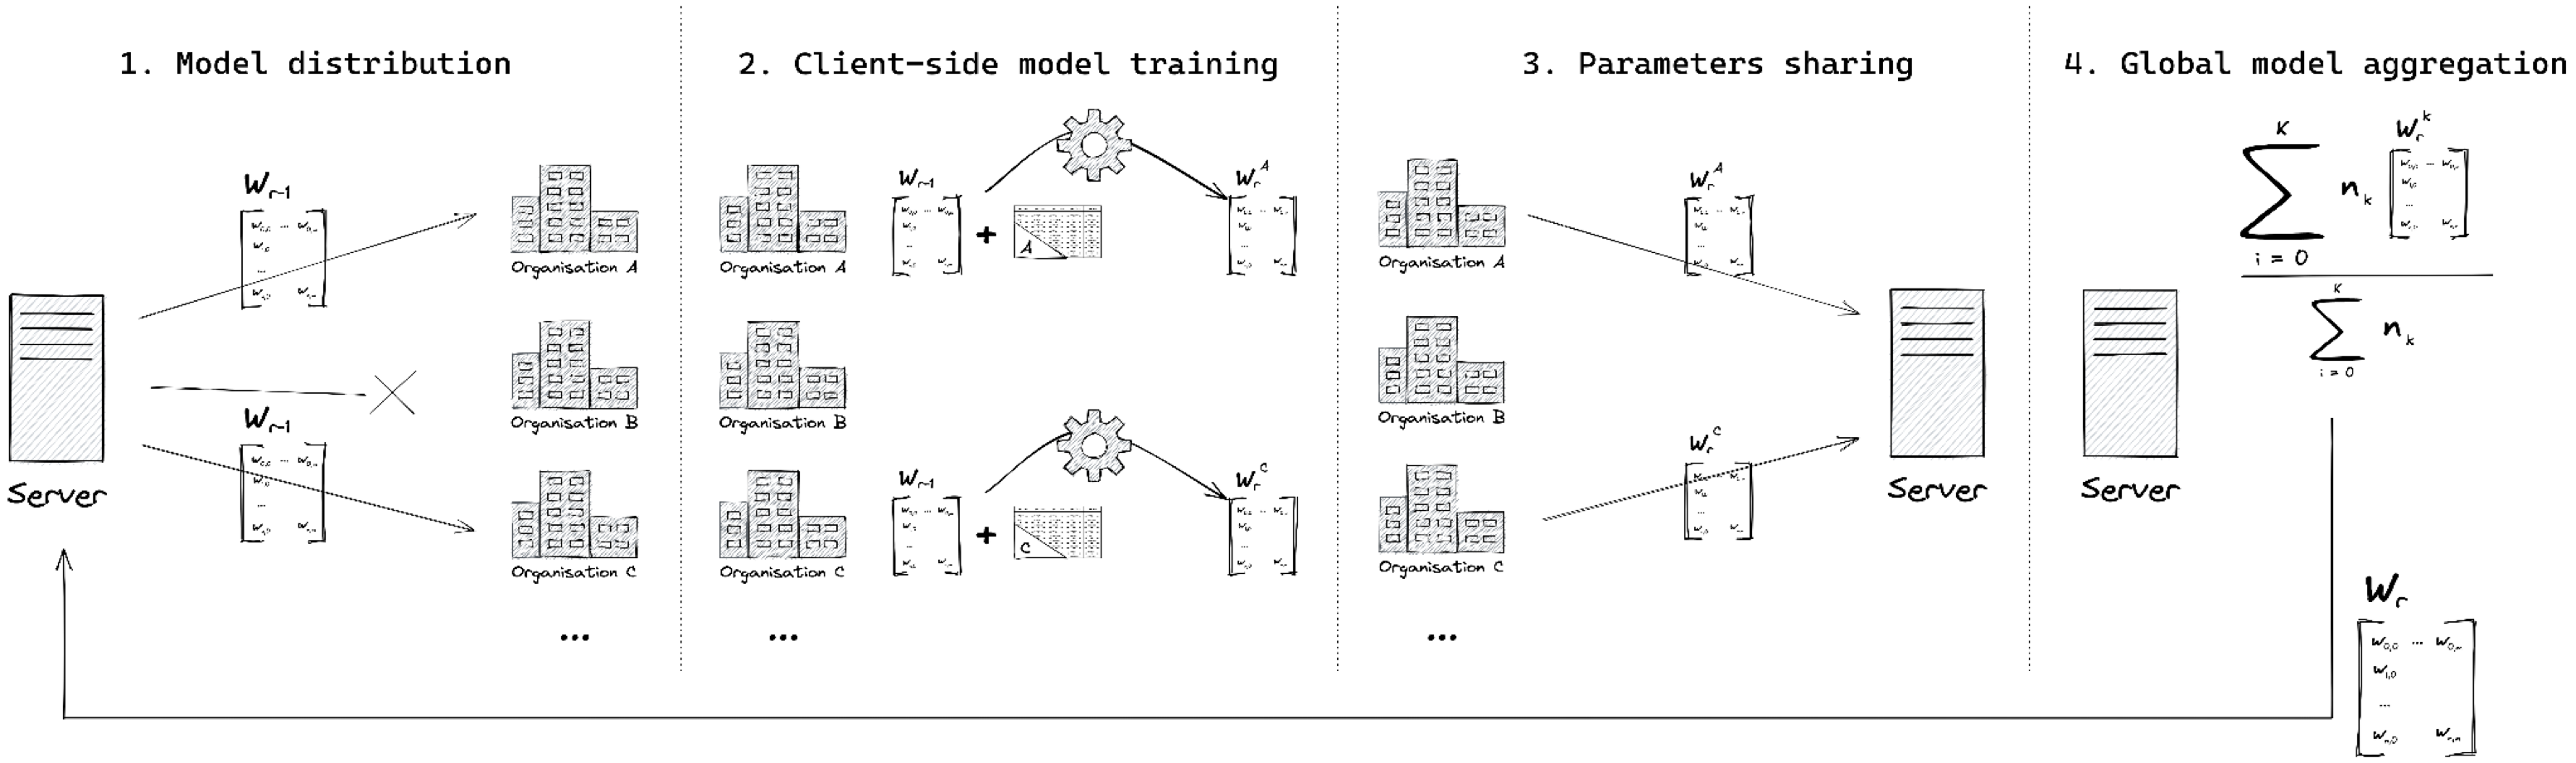

The `flwr` library is a Python implementation of FL. It provides a set of tools to implement a
federated learning in simulations, as well as in real-world applications. It is designed to be easy
to use, and to be compatible with a wide range of ML frameworks, including Tensorflow/Keras.

Its main components are:
- `flwr.client`: contains the `Client` class, which represents a client in the FL process. It
  provides a set of methods that are called by the server during the training process. The client
  can be simulated using `ray`, or run on a real device.
- `flwr.server`: contains the `Server` class, which represents the server in the FL process. It
  acts as a coordinator, and is responsible for managing the training process. 
- `flwr.strategy`: contains the implementation of the aggregation algorithm. `FedAvg` is the most
  common algorithm, and is the one we will use in this tutorial, but `flwr` also provides other
  strategies, such as `FedProx`, `FedOpt`, `FedYogi`, `FedAdagrad`, and `FedAdam`.

Below is a diagram of `flwr`'s architecture, you can find more information in the [documentation](https://flower.dev/docs/architecture.html).

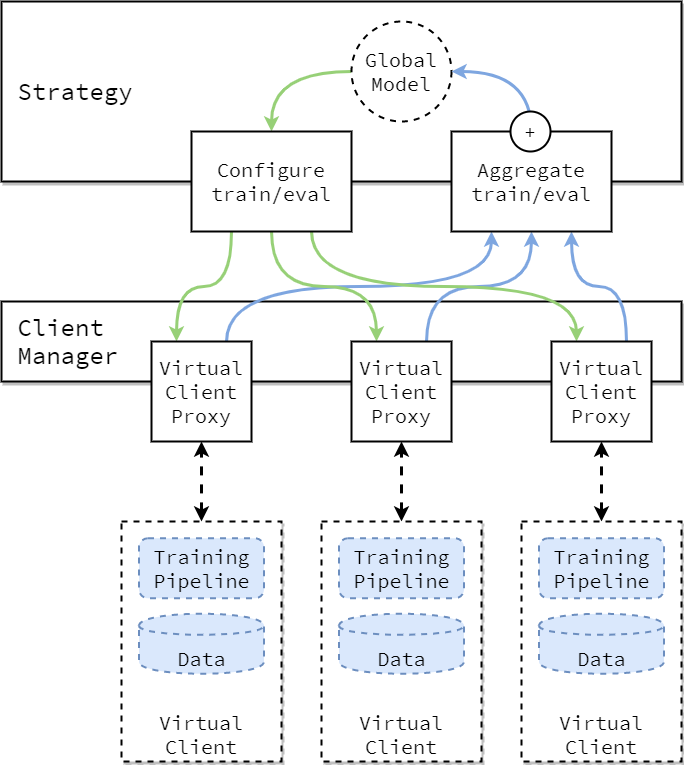


### Step 1: Creating clients

The first step is to create a `Client` class that will represent our client in the FL process. We
will use the `flwr.client.NumPyClient` class, which is a simple client that uses NumPy arrays to
represent model parameters and data.

The client needs to implement one main method:
- `fit`: this method is called by the server to train the model on the client's local data. It
  takes a set of parameters, and returns the updated parameters.

While we could evaluate each client individually (called federated evaluation), we will use the
server to evaluate the model directly on the test set. This is done by implementing the `evaluate`
method on the server's strategy. 

In [ ]:
class FlwrClient(fl.client.NumPyClient):
    ### TODO: CyberSchool ###
    pass

    ### END TODO ###

We also need to write a function that will properly instantiate clients with the correct data. We
can create a list of client IDs, and map them to the corresponding data partition. 

In [ ]:
CIDS = ### TODO: CyberSchool ###

cids_parts = ### TODO: CyberSchool ###

def client_fn(cid: str) -> fl.client.NumPyClient:
    ### TODO: CyberSchool ###

    ### END TODO ###

### Step 2: Prepare the server

The next step is to instanciate a `Strategy` class, which will act as a coordinator for the FL
process. Since we are simulating federated learning, we do not need to use a real server, and can
use the `flwr.simulation.start_simulation` function. For our strategy to be able to evaluate the
model, we also need to create an `evaluate_fn` function that will be called by the strategy.

Do not hesitate to try other strategies to see how they impact the results!

In [ ]:
from typing import Optional
from flwr.common import Scalar, NDArrays, ndarrays_to_parameters

FL_WEIGHTS = False
init_params = ndarrays_to_parameters(create_model().get_weights())

    
# The `evaluate` function will be called after every round
def evaluate_fn(
    server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    ### TODO: CyberSchool ###
    pass

    ### END TODO ###

strat = fl.server.strategy.FedAvg(
    ### TODO: CyberSchool ###

    ### END TODO ###
)

### Step 3: Federate the training!

We reproduce a typical "cross-silo" setting in federated learning, where each organization has its
own local data, using the `partitions` we prepared earlier.  We're doing this purely for
experimentation purposes, in the real world there's no need for data splitting because each
organization already has their own data (so the data is naturally partitioned).

Each organization will act as a client in the federated learning system. So having ten organizations
participate in a federation means having ten clients connected to the federated learning server. 

In [ ]:
print(f"Number of clients: {NUM_CLIENTS}")

We now have a list of ten training sets (`partitions`) representing the data of ten different
organizations. There's also a single testing set that we gave to the `evaluate_fn` function (we did
not split the test set). Again, this is only necessary for building research or educational systems,
actual federated learning systems have their data naturally distributed across multiple partitions.

Let's take a look at the shapes and characteristics of the training sets before moving on to the training.

In [ ]:
for k, v in cids_parts.items():
    print(f"  {k}: \t X: {v[0].shape}, lacks: {v[3]}")

In [ ]:
hist = fl.simulation.start_simulation(
    client_fn=client_fn,
    clients_ids=CIDS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strat,
)


### Step 4: Analyzing the results

In [ ]:
loss = [i[1] for i in hist.losses_centralized]
acc = [i[1] for i in hist.metrics_centralized["accuracy"]]

# plot training history, loss and accuracy side by side
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
_min = np.min(loss)
ax1.axhline(y=_min, label=f"Min: {_min:.4f}", linestyle='--', color='lightcoral')
ax1.plot(loss)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
_max = np.max(acc)
ax2.axhline(y=_max, label=f"Max: {_max:.4f}", linestyle='--', color='lightcoral')
ax2.plot(acc, color='orange')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()
plt.show()

In [ ]:
# try with the baseline model
model.set_weights(LOCAL_WEIGHTS)

inferences = model.predict(X_test)

y_pred = np.argmax(np.round(inferences), axis=1)
y_pred_lack = y_pred[m_test.isin(part[3])]
print(f"Percentage of removed attacks detected (Baseline): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")

model.set_weights(FL_WEIGHTS)

inferences = model.predict(X_test)

y_pred = np.argmax(np.round(inferences), axis=1)

# remember: part[3] contains a list of the removed classes
y_pred_lack = y_pred[m_test.isin(part[3])]

print(f"Percentage of removed attacks detected (FL): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")

# try with the baseline model
model.set_weights(bl_weights)

inferences = model.predict(X_test)

y_pred = np.argmax(np.round(inferences), axis=1)
y_pred_lack = y_pred[m_test.isin(part[3])]
print(f"Percentage of removed attacks detected (Baseline): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")

## Final remarks

Congratulations, you just trained a multi-layer perceptron on the NSL-KDD dataset using federated
learning! You can now try to improve the results by changing the model, the hyperparameters, or the
FL strategy. You have only scratched the surface of the topic!

We've seen together how federated learning can help improve the performance of a model trained on
local data. However, we have not discussed the heterogeneity and security aspects of federated
learning, nor the challenges of deploying it in a real-world settings. FL's literature is full of
open challenges to look at!

If you enjoyed this tutorial, please share this work with your colleagues and friends. You can also
check out the [Flower documentation](https://flower.dev/docs/index.html) for more information on
this framework. 

Thank you for reading!

## Sources

<a name="note1"></a>[\[1\]](#ref1) M. Tavallaee, E. Bagheri, W. Lu, and A. A. Ghorbani, “A detailed analysis of the KDD CUP 99 data set,” in 2009 IEEE Symposium on Computational Intelligence for Security and Defense Applications, Jul. 2009

<a name="note3"></a>[\[3\]](#ref3) https://www.tensorflow.org/versions/r2.8/api_docs/python/tf/config/experimental/enable_op_determinism


## Credits

This tutorial is heavily based on the Flower team's tutorials and documentation. You can find the links to some of them below:

- [An Introduction to Federated Learning](https://github.com/adap/flower/blob/main/doc/source/tutorial/Flower-1-Intro-to-FL-PyTorch.ipynb)
- [Flower Quickstart (Simulation with TensorFlow/Keras)](https://github.com/adap/flower/blob/main/examples/simulation_tensorflow/sim.ipynb)